This is to play with pytorch framework for EHR modeling. In general, a patient's health record can be represented as a sequence of visits. Each visit has certain features, and normally stored as a list of medical, procedure, surgical, demographic codes.

* This notebook is to present how our logistic regression model works on the cerner sample data for predicting heart failure onset risk using pytorch library
* For this demonstration, the data is the original 1 hospital (h143) previously used by retain, with 42,729 patients in total
* The logistic regression model has the architecture of an embedding layer (embedding dimension =2), a linear activation and sigmoid transformation. The hyperparameters used are bayesian optimized already (lr = np.exp(-9.0790), L2 = np.exp(-7.3835))
* Our model achieves overall 0.8132 test auc, with corresponding 0.7739 validation auc on epoch 27
* Since the embedding dimension =2, we plot the embedded matrix colored by predicted labels vs embedded matrix colored by real labels to demonstrate how the classifications evolves with epoches
* Visualization of training loss, training auc, validation auc, and test auc for each epoch as well as how average loss, training auc, validation auc and test auc change with epochs are shown at the end
* Since github does not render Plotly graph, we upload a static one, and if you're curious about the original interactive plot, you can also click on the link provided

In [1]:
from __future__ import print_function, division
from io import open
import string
import re
import random
import pandas as pd
import os
import sys
import argparse
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torchviz import make_dot, make_dot_from_trace

from sklearn.metrics import roc_auc_score  
from sklearn.metrics import roc_curve 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

try:
    import cPickle as pickle
except:
    import pickle

In [2]:
import model as model 
import Loaddata as Loaddata
import TrainVaTe as TVT

# check GPU availability
use_cuda = torch.cuda.is_available()
use_cuda

True

In [3]:
parser = argparse.ArgumentParser(description='Predictive Analytics on EHR using Pytorch: LR, RNN')
# learning
parser.add_argument('-lr', type=float, default=np.exp(-9.0790), help='initial learning rate [default: 0.0001]')
parser.add_argument('-L2', type=float, default=np.exp(-7.3835), help='L2 regularization [default: 0.0006]')
parser.add_argument('-epochs', type=int, default=30, help='number of epochs for train [default: 30]')
parser.add_argument('-batch_size', type=int, default=1, help='batch size for training [default: 1]')
# data 
parser.add_argument('-seq_file', type = str, default = 'data/cerner/hospital_data/h143.visits' , help='the path to the Pickled file containing visit information of patients')
parser.add_argument('-label_file', type = str, default = 'data/cerner/hospital_data/h143.labels', help='the path to the Pickled file containing label information of patients')
# model
parser.add_argument('-which_model', type = str, default = 'LR', help='choose from {"LR", "RNN"}')
parser.add_argument('-input_size', type = int, default =20000, help='input dimension [default: 20000]')
parser.add_argument('-embed_dim', type=int, default=128, help='number of embedding dimension [default: 128]')
parser.add_argument('-hidden_size', type=int, default=128, help='size of hidden layers [default: 128]')
parser.add_argument('-dropout', type=float, default=0.1, help='the probability for dropout [default: 0.1]')
parser.add_argument('-eb_mode', type=str, default='sum', help= "embedding mode [default: 'sum']")

_StoreAction(option_strings=['-eb_mode'], dest='eb_mode', nargs=None, const=None, default='sum', type=<class 'str'>, choices=None, help="embedding mode [default: 'sum']", metavar=None)

In [4]:
# a block to simulate args reading from command line 
args = parser.parse_args(args=[])
args.lr = np.exp(-9.0790)
args.L2 = np.exp(-7.3835)
args.epochs = 30
args.batch_size = 1
args.seq_file = 'Data/h143.visits'
args.label_file = 'Data/h143.labels'
args.which_model = 'LR'
args.input_size = 20000

In [5]:
# load and prepare data
set_x = pickle.load(open(args.seq_file, 'rb'), encoding='bytes')
set_y = pickle.load(open(args.label_file, 'rb'),encoding='bytes')

#preprocessing
# LR needs to have input format of list; list of list for NN models
if args.which_model == 'LR':
    model_x = []
    for patient in set_x:
        model_x.append([each for visit in patient for each in visit])  
else: 
    model_x = set_x     
    
merged_set= [[set_y[i],model_x[i]] for i in range(len(set_y))] 
print("\nLoading and preparing data...")    
train1, valid1, test1 = Loaddata.load_data(merged_set)
print("\nSample data after split:")  
print(train1[0])
print("model is", args.which_model)


Loading and preparing data...

Sample data after split:
[0, [1667, 144, 62, 85, 1667, 144, 62, 85]]
model is LR


Parameter containing:
-2.7444e+00 -4.0943e-01
-1.5546e-01 -8.4493e-01
 2.1925e+00 -9.2346e-01
           ⋮            
-8.9249e-01 -9.2026e-02
-6.8342e-01  1.5138e-01
 1.1895e+00 -9.2700e-01
[torch.FloatTensor of size 20000x2]

15815


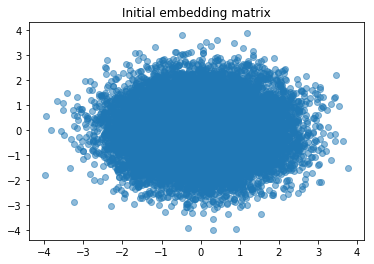

In [6]:
# model loading part
if args.which_model == 'LR': 
    ehr_model = model.EHR_LR(args.input_size)
else: 
    ehr_model = model.EHR_RNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode) 
    
if use_cuda:
    ehr_model = ehr_model.cuda()

optimizer = optim.Adam(ehr_model.parameters(), lr=args.lr, weight_decay=args.L2)

In [7]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [8]:
## train validation and test part
current_loss_allep=[]
all_losses_allep=[]
avg_losses_allep=[]
train_auc_allep =[]
valid_auc_allep =[]
test_auc_allep=[]


 Current running on: Epoch  0 Training loss:  Average loss 1.0524796696585816


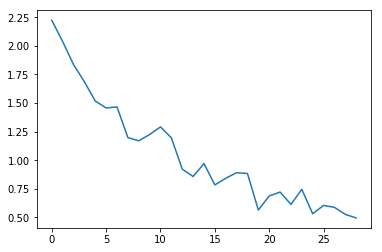

Epoch  0 Summary:  Training_auc : 0.5264991218277865  , Validation_auc :  0.5111716000386867  ,& Test_auc :  0.5322597334857692  Avg Loss:  1.0524796696585816 Train Time (0m 56s) Eval Time (0m 30s)


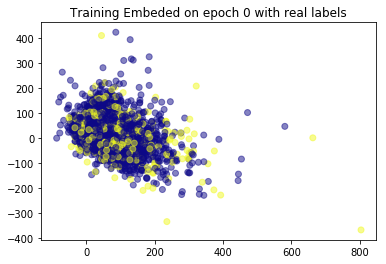

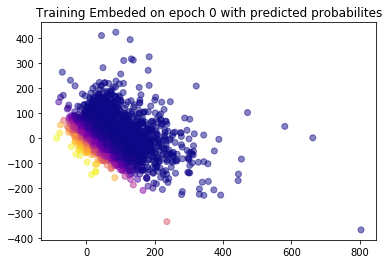


 Current running on: Epoch  1 Training loss:  Average loss 0.4129533804653233


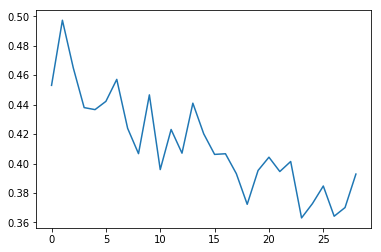

Epoch  1 Summary:  Training_auc : 0.576652796630236  , Validation_auc :  0.5484507020704481  ,& Test_auc :  0.5763175120479651  Avg Loss:  0.4129533804653233 Train Time (0m 56s) Eval Time (0m 33s)


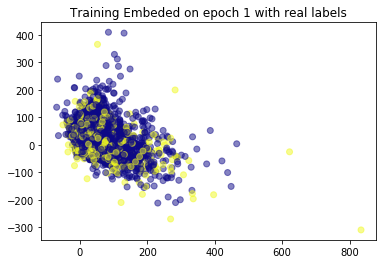

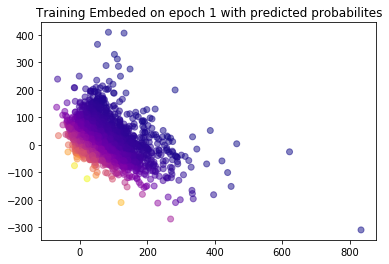


 Current running on: Epoch  2 Training loss:  Average loss 0.36929770704180653


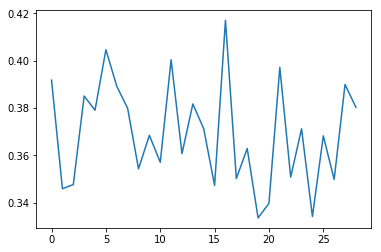

Epoch  2 Summary:  Training_auc : 0.6360588784678968  , Validation_auc :  0.6148989091775419  ,& Test_auc :  0.6308435791913198  Avg Loss:  0.36929770704180653 Train Time (1m 2s) Eval Time (0m 31s)


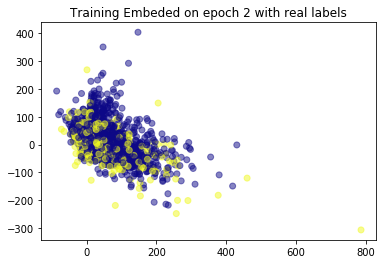

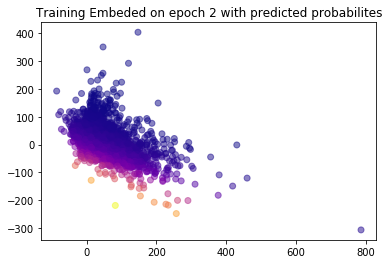


 Current running on: Epoch  3 Training loss:  Average loss 0.35731163190347215


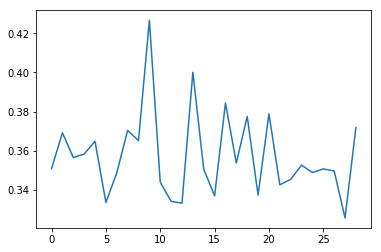

Epoch  3 Summary:  Training_auc : 0.6850829884692096  , Validation_auc :  0.6671816695053296  ,& Test_auc :  0.6806992837168295  Avg Loss:  0.35731163190347215 Train Time (0m 56s) Eval Time (0m 31s)


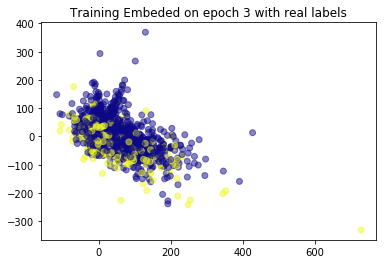

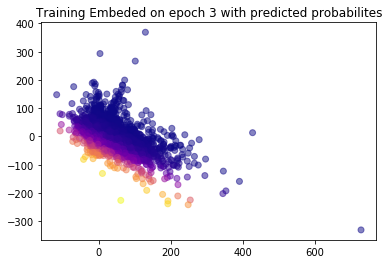


 Current running on: Epoch  4 Training loss:  Average loss 0.34845254465753195


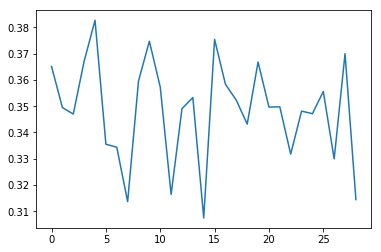

Epoch  4 Summary:  Training_auc : 0.7179957635531559  , Validation_auc :  0.7036345813067904  ,& Test_auc :  0.719683605113379  Avg Loss:  0.34845254465753195 Train Time (1m 5s) Eval Time (0m 33s)


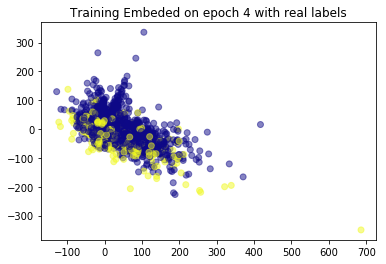

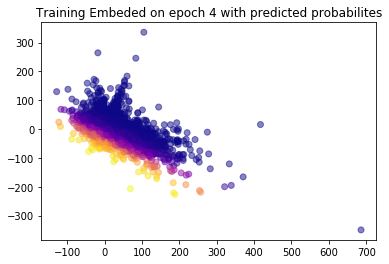


 Current running on: Epoch  5 Training loss:  Average loss 0.34211227311294184


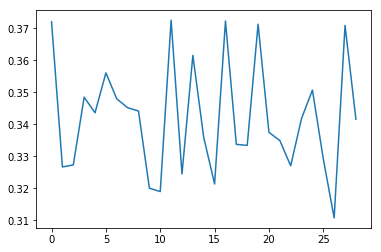

Epoch  5 Summary:  Training_auc : 0.731807129976487  , Validation_auc :  0.7192002347429385  ,& Test_auc :  0.7341529929073308  Avg Loss:  0.34211227311294184 Train Time (1m 5s) Eval Time (0m 31s)


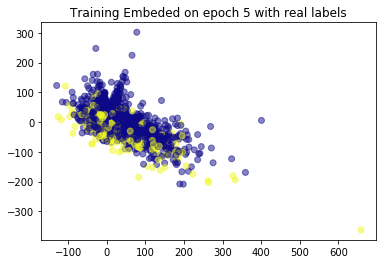

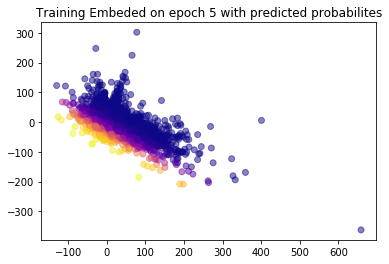


 Current running on: Epoch  6 Training loss:  Average loss 0.33765141235974866


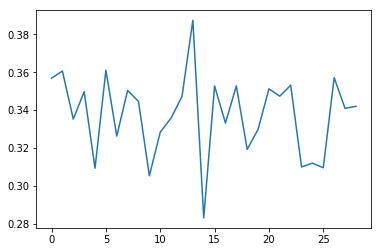

Epoch  6 Summary:  Training_auc : 0.7464155243229291  , Validation_auc :  0.7338216707730288  ,& Test_auc :  0.7509584798338508  Avg Loss:  0.33765141235974866 Train Time (1m 0s) Eval Time (0m 30s)


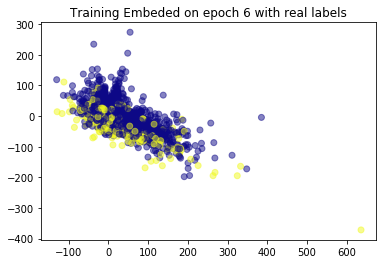

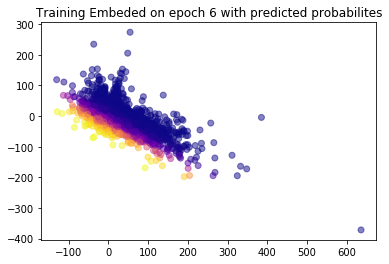


 Current running on: Epoch  7 Training loss:  Average loss 0.3345894298153153


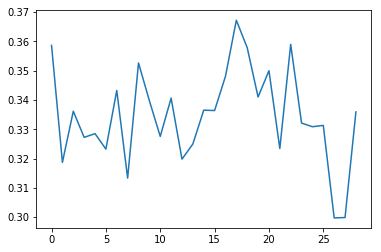

Epoch  7 Summary:  Training_auc : 0.7532833455339633  , Validation_auc :  0.7389257997024186  ,& Test_auc :  0.7585123044117812  Avg Loss:  0.3345894298153153 Train Time (1m 1s) Eval Time (0m 33s)


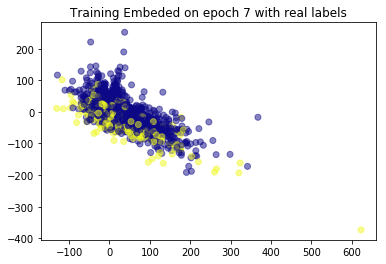

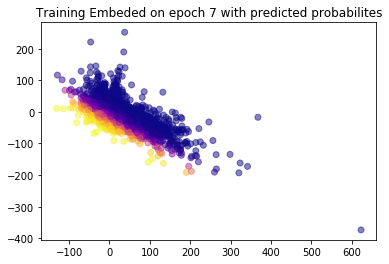


 Current running on: Epoch  8 Training loss:  Average loss 0.3310955121283237


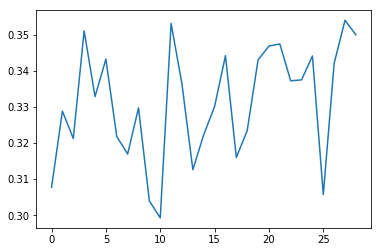

Epoch  8 Summary:  Training_auc : 0.7706873767524393  , Validation_auc :  0.7581330832905757  ,& Test_auc :  0.780064639259954  Avg Loss:  0.3310955121283237 Train Time (0m 59s) Eval Time (0m 31s)


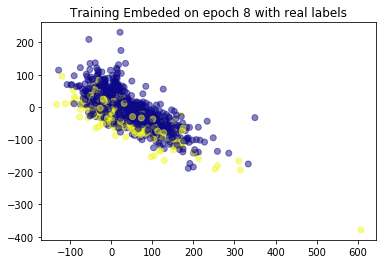

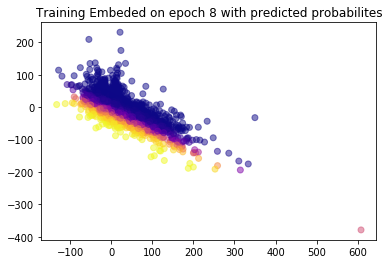


 Current running on: Epoch  9 Training loss:  Average loss 0.3296711037057274


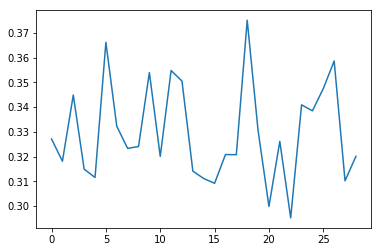

Epoch  9 Summary:  Training_auc : 0.7755985269019624  , Validation_auc :  0.7621334395577914  ,& Test_auc :  0.7874548192812041  Avg Loss:  0.3296711037057274 Train Time (0m 57s) Eval Time (0m 32s)


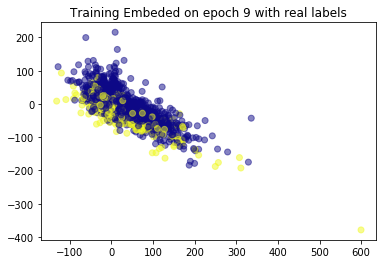

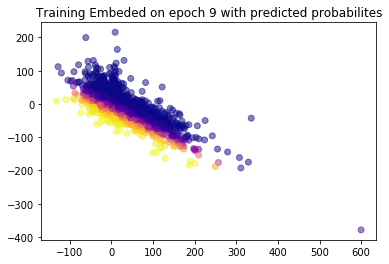


 Current running on: Epoch  10 Training loss:  Average loss 0.32772463463765555


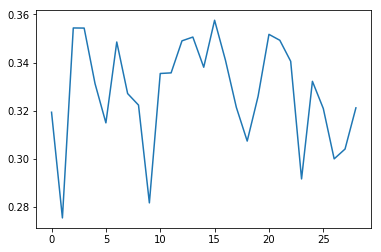

Epoch  10 Summary:  Training_auc : 0.7759044584823771  , Validation_auc :  0.7589314059932669  ,& Test_auc :  0.7887034673609675  Avg Loss:  0.32772463463765555 Train Time (0m 56s) Eval Time (0m 32s)


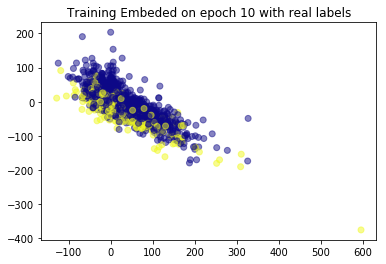

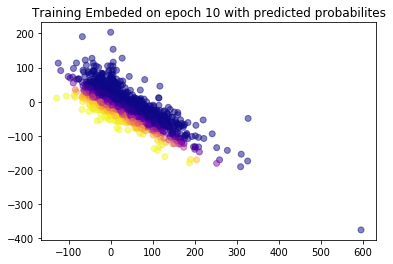


 Current running on: Epoch  11 Training loss:  Average loss 0.3284035680793778


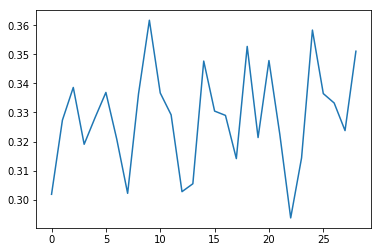

Epoch  11 Summary:  Training_auc : 0.7829374277970528  , Validation_auc :  0.7667438761108079  ,& Test_auc :  0.7960928315389769  Avg Loss:  0.3284035680793778 Train Time (0m 55s) Eval Time (0m 32s)


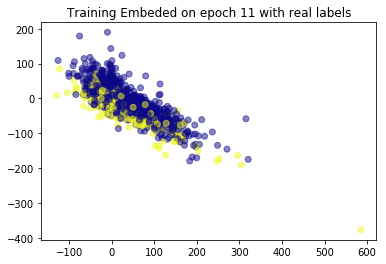

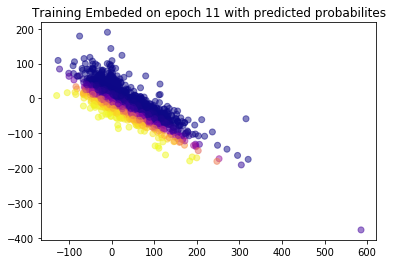


 Current running on: Epoch  12 Training loss:  Average loss 0.3260550894292158


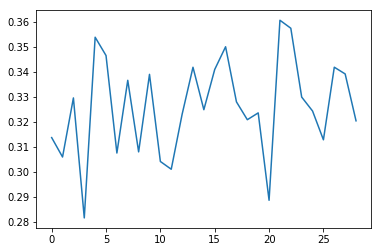

Epoch  12 Summary:  Training_auc : 0.7866957741888729  , Validation_auc :  0.7703658350668575  ,& Test_auc :  0.7995347381972638  Avg Loss:  0.3260550894292158 Train Time (1m 0s) Eval Time (0m 32s)


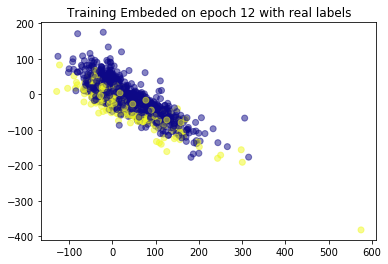

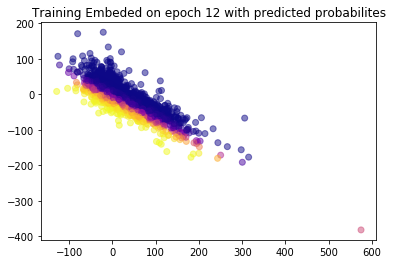


 Current running on: Epoch  13 Training loss:  Average loss 0.3242389723232216


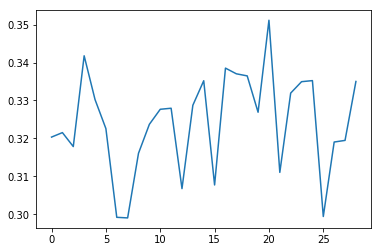

Epoch  13 Summary:  Training_auc : 0.7865366758962384  , Validation_auc :  0.7700396210671951  ,& Test_auc :  0.8017946239737711  Avg Loss:  0.3242389723232216 Train Time (0m 59s) Eval Time (0m 31s)


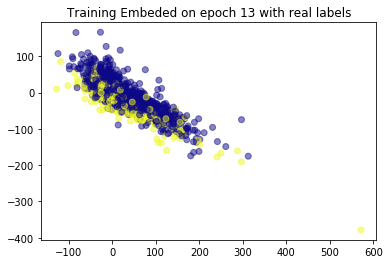

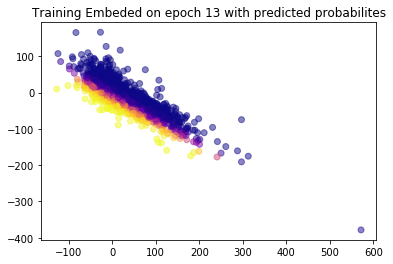


 Current running on: Epoch  14 Training loss:  Average loss 0.3227578916127969


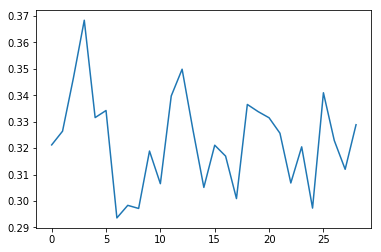

Epoch  14 Summary:  Training_auc : 0.7847545957650726  , Validation_auc :  0.7638617726916808  ,& Test_auc :  0.7992423263824396  Avg Loss:  0.3227578916127969 Train Time (0m 55s) Eval Time (0m 29s)


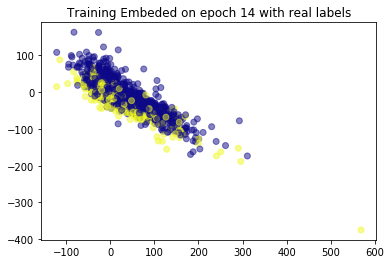

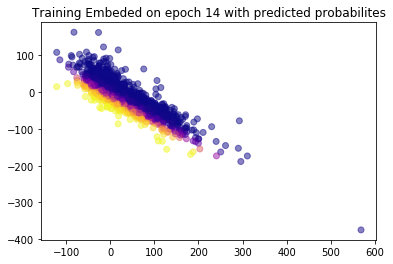


 Current running on: Epoch  15 Training loss:  Average loss 0.32086270378039


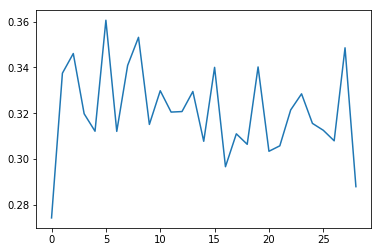

Epoch  15 Summary:  Training_auc : 0.791062318644378  , Validation_auc :  0.7705699237249376  ,& Test_auc :  0.8041563541814822  Avg Loss:  0.32086270378039 Train Time (0m 56s) Eval Time (0m 30s)


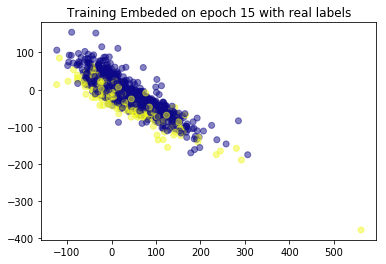

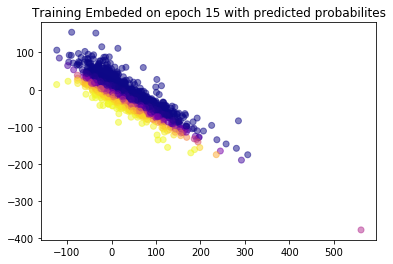


 Current running on: Epoch  16 Training loss:  Average loss 0.3215257013054231


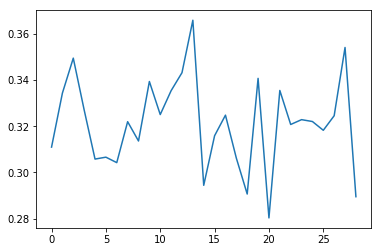

Epoch  16 Summary:  Training_auc : 0.7921895894254681  , Validation_auc :  0.7704215701220762  ,& Test_auc :  0.8056766780603708  Avg Loss:  0.3215257013054231 Train Time (0m 56s) Eval Time (0m 30s)


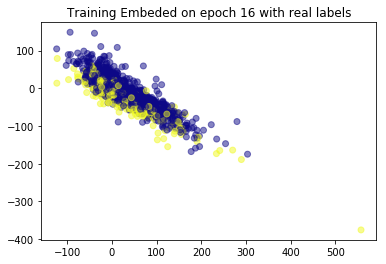

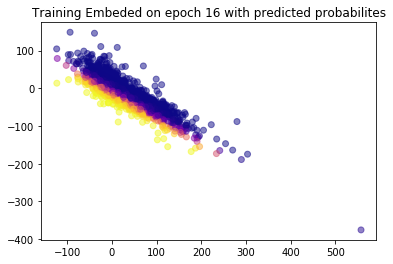


 Current running on: Epoch  17 Training loss:  Average loss 0.3203490821662832


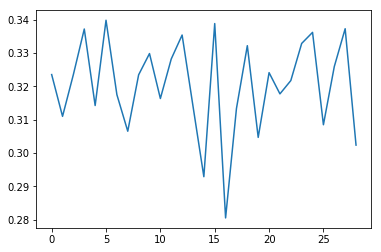

Epoch  17 Summary:  Training_auc : 0.7946836000058727  , Validation_auc :  0.7734099526415957  ,& Test_auc :  0.8077526591730559  Avg Loss:  0.3203490821662832 Train Time (0m 56s) Eval Time (0m 29s)


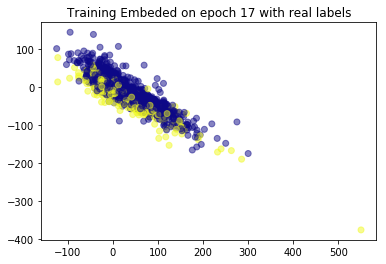

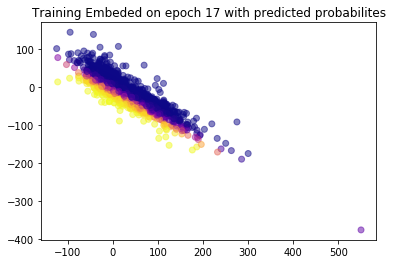


 Current running on: Epoch  18 Training loss:  Average loss 0.31998706058489845


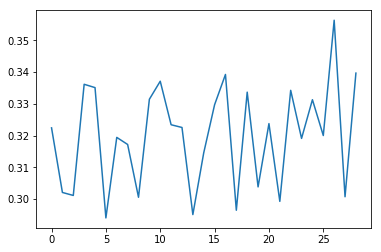

Epoch  18 Summary:  Training_auc : 0.7949727158858519  , Validation_auc :  0.7724072680697692  ,& Test_auc :  0.8071090948300832  Avg Loss:  0.31998706058489845 Train Time (0m 58s) Eval Time (0m 32s)


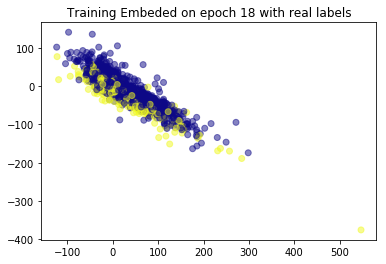

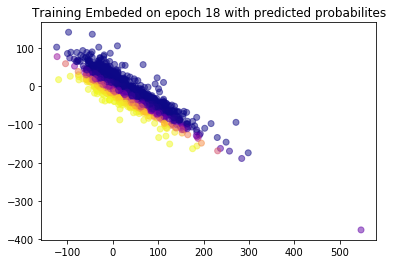


 Current running on: Epoch  19 Training loss:  Average loss 0.31995449009381693


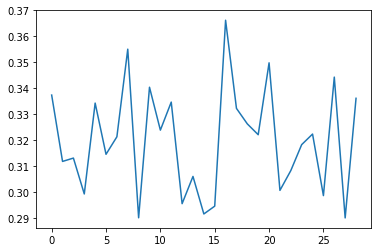

Epoch  19 Summary:  Training_auc : 0.7969787137132976  , Validation_auc :  0.773481533938004  ,& Test_auc :  0.8090539971287757  Avg Loss:  0.31995449009381693 Train Time (0m 55s) Eval Time (0m 31s)


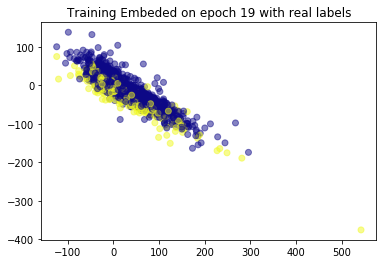

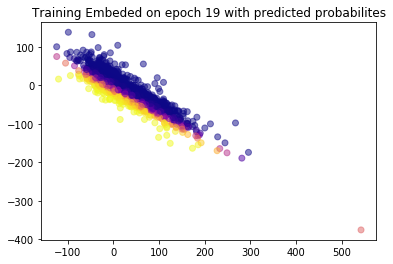


 Current running on: Epoch  20 Training loss:  Average loss 0.31730186773070895


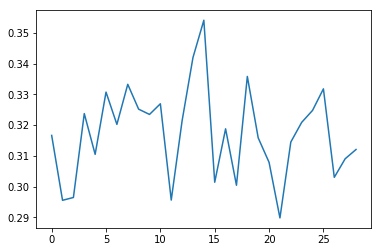

Epoch  20 Summary:  Training_auc : 0.7938166418158498  , Validation_auc :  0.7711980359403678  ,& Test_auc :  0.8067316993443612  Avg Loss:  0.31730186773070895 Train Time (0m 54s) Eval Time (0m 32s)


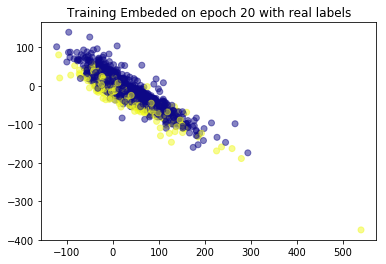

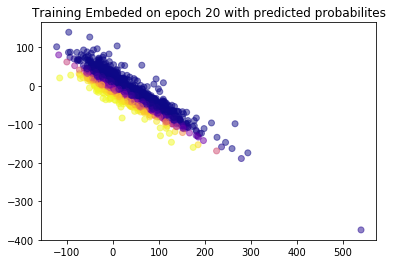


 Current running on: Epoch  21 Training loss:  Average loss 0.31801549051899075


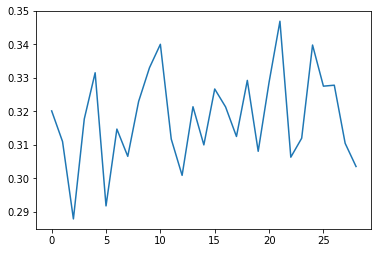

Epoch  21 Summary:  Training_auc : 0.7960961828616089  , Validation_auc :  0.7724280321099488  ,& Test_auc :  0.8076941224205415  Avg Loss:  0.31801549051899075 Train Time (0m 55s) Eval Time (0m 31s)


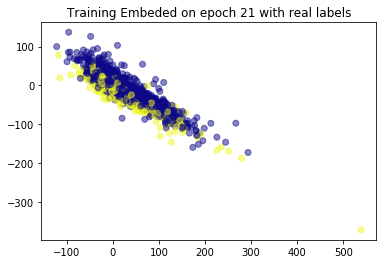

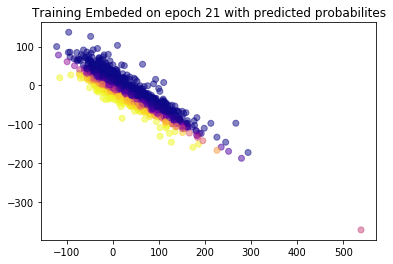


 Current running on: Epoch  22 Training loss:  Average loss 0.31886539357896027


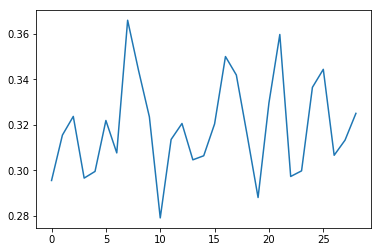

Epoch  22 Summary:  Training_auc : 0.7925109816340115  , Validation_auc :  0.7637606846013332  ,& Test_auc :  0.8019108136486223  Avg Loss:  0.31886539357896027 Train Time (0m 55s) Eval Time (0m 32s)


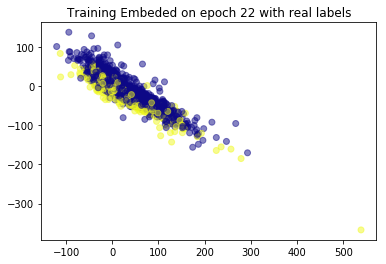

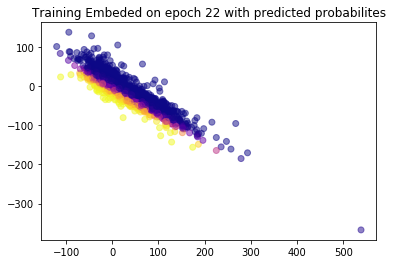


 Current running on: Epoch  23 Training loss:  Average loss 0.3166224322872596


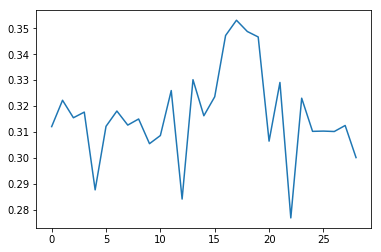

Epoch  23 Summary:  Training_auc : 0.7949817906023623  , Validation_auc :  0.769373532515121  ,& Test_auc :  0.8054378399516804  Avg Loss:  0.3166224322872596 Train Time (0m 58s) Eval Time (0m 33s)


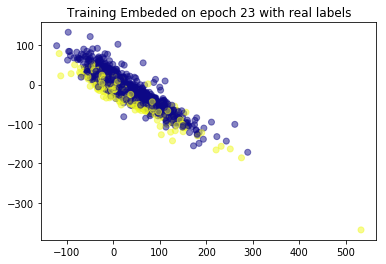

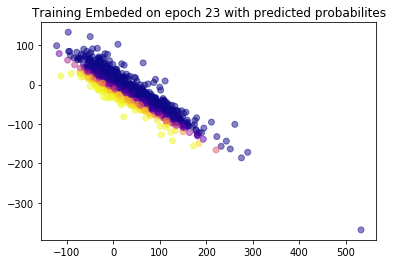


 Current running on: Epoch  24 Training loss:  Average loss 0.31590192023339975


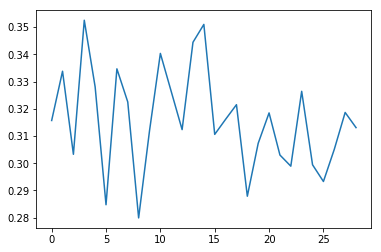

Epoch  24 Summary:  Training_auc : 0.7979363710540508  , Validation_auc :  0.7737891695859269  ,& Test_auc :  0.8097704434679103  Avg Loss:  0.31590192023339975 Train Time (0m 56s) Eval Time (0m 30s)


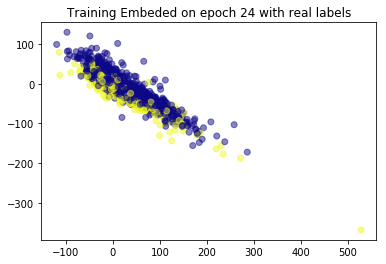

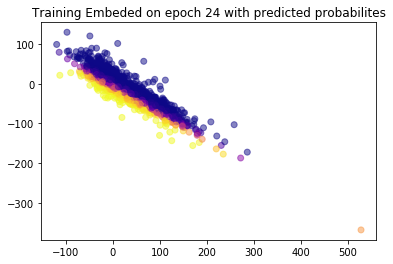


 Current running on: Epoch  25 Training loss:  Average loss 0.3158404966016962


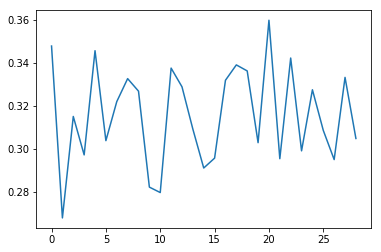

Epoch  25 Summary:  Training_auc : 0.7979448322535719  , Validation_auc :  0.7674954797230951  ,& Test_auc :  0.8063043334601517  Avg Loss:  0.3158404966016962 Train Time (0m 55s) Eval Time (0m 30s)


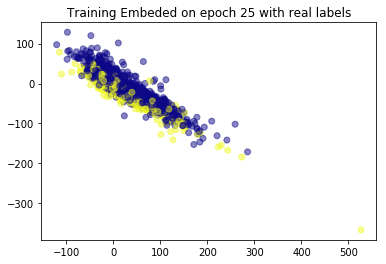

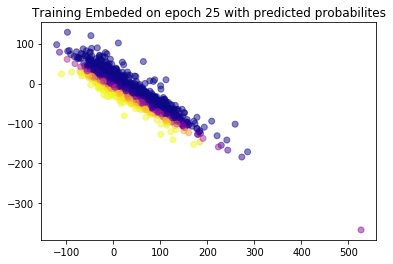


 Current running on: Epoch  26 Training loss:  Average loss 0.3149788642556023


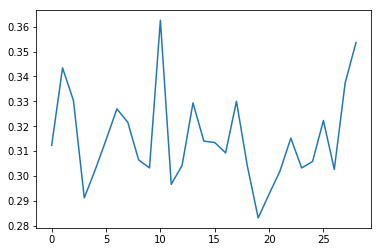

Epoch  26 Summary:  Training_auc : 0.7973630580998669  , Validation_auc :  0.7700516423536148  ,& Test_auc :  0.8089518807498253  Avg Loss:  0.3149788642556023 Train Time (1m 0s) Eval Time (0m 32s)


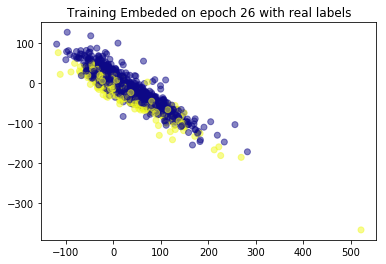

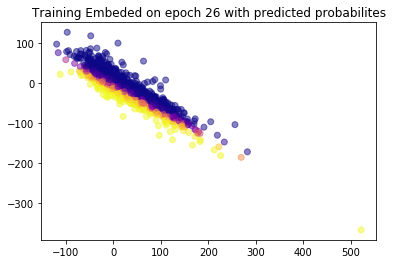


 Current running on: Epoch  27 Training loss:  Average loss 0.31466034776012974


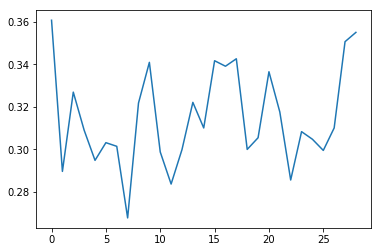

Epoch  27 Summary:  Training_auc : 0.8016175690182071  , Validation_auc :  0.7738689472139849  ,& Test_auc :  0.813242060417543  Avg Loss:  0.31466034776012974 Train Time (0m 57s) Eval Time (0m 30s)


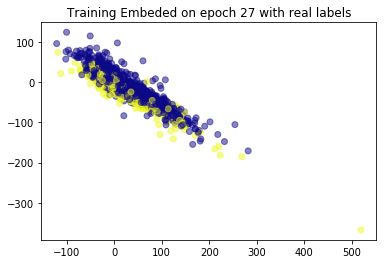

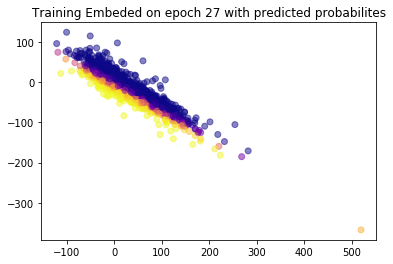


 Current running on: Epoch  28 Training loss:  Average loss 0.3167533776933303


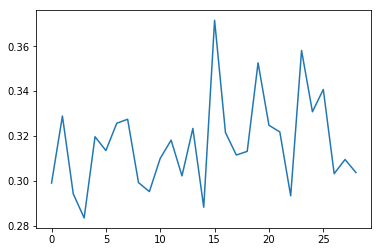

Epoch  28 Summary:  Training_auc : 0.7985213461659604  , Validation_auc :  0.7711696219906486  ,& Test_auc :  0.8077935193220234  Avg Loss:  0.3167533776933303 Train Time (0m 57s) Eval Time (0m 30s)


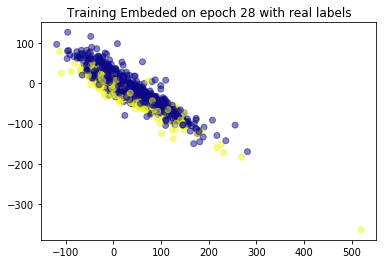

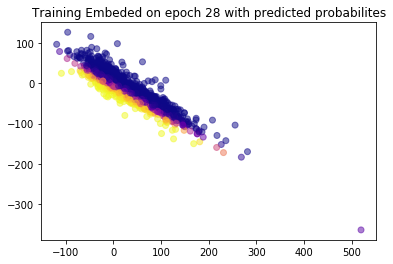


 Current running on: Epoch  29 Training loss:  Average loss 0.31573922483139993


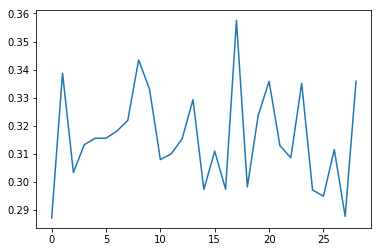

Epoch  29 Summary:  Training_auc : 0.7993838230144968  , Validation_auc :  0.7713455699100643  ,& Test_auc :  0.8085126851386268  Avg Loss:  0.31573922483139993 Train Time (0m 58s) Eval Time (0m 31s)


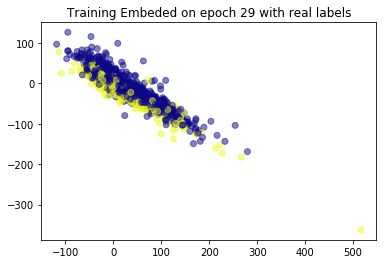

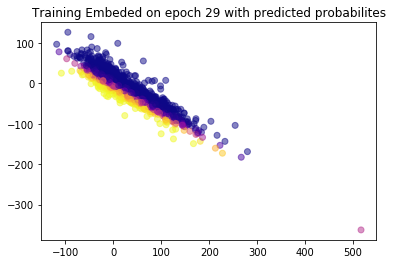

In [9]:
# train, validation, and test for each epoch, no early stopping
for ep in range(args.epochs):
    start = time.time()
    current_loss, train_loss, em = TVT.train(train1, model= ehr_model, optimizer = optimizer, batch_size = args.batch_size) 
    avg_loss = np.mean(train_loss)
    train_time = timeSince(start)
    print ('\n Current running on: Epoch ', ep,'Training loss:',' Average loss', avg_loss)
    TVT.showPlot(train_loss)
    eval_start = time.time()
    train_auc, y_real, y_hat, emb = TVT.calculate_auc(model= ehr_model, data = train1, which_model = args.which_model, batch_size = args.batch_size)
    valid_auc, _, _, _  = TVT.calculate_auc(model = ehr_model, data = valid1, which_model = args.which_model, batch_size = args.batch_size)
    test_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test1, which_model = args.which_model, batch_size = args.batch_size)
    eval_time = timeSince(eval_start)
    print ("Epoch ", ep, "Summary:  Training_auc :", train_auc, " , Validation_auc : ", valid_auc, " ,& Test_auc : " , test_auc, " Avg Loss: ", avg_loss, 'Train Time (%s) Eval Time (%s)'%(train_time,eval_time) )   
    current_loss_allep.append(current_loss)
    all_losses_allep.append(train_loss)
    avg_losses_allep.append(avg_loss)
    train_auc_allep.append(train_auc)
    valid_auc_allep.append(valid_auc)
    test_auc_allep.append(test_auc)
    
    #Visualizing embedding matrix 
    color1 = np.array([item for item in y_real])
    plt.scatter(emb[1:,0],emb[1:,1], c= color1, cmap= 'plasma', alpha = 0.5)
    plt.title('Training Embeded on epoch '+str(ep)+' with real labels')
    plt.show()
    color2 = np.array([item for item in y_hat])
    plt.scatter(emb[1:,0],emb[1:,1], c= color2, cmap='plasma', alpha = 0.5)
    plt.title('Training Embeded on epoch '+str(ep)+' with predicted probabilites')
    plt.show()

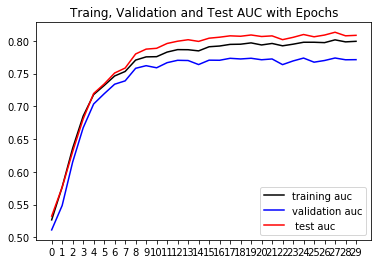

In [10]:
#plot all three auc in a same plot 
plt.plot(train_auc_allep, color= 'black', label = 'training auc')
plt.plot(valid_auc_allep, color ='blue', label = 'validation auc')
plt.plot(test_auc_allep, color = 'red', label =' test auc')
plt.xticks(range(args.epochs))
plt.title('Traing, Validation and Test AUC with Epochs' )
plt.legend(loc= 'lower right')
plt.show()

In [11]:
#fancier plot
import plotly.plotly as py 
import plotly.graph_objs as go
py.sign_in('GinnyJZ','xJj3WJ9XiB3ijm4frOXc') #get my own sign in please

train_auc_fg= go.Scatter(x= np.arange(args.epochs), y=train_auc_allep, name ='Training auc')
valid_auc_fg= go.Scatter(x= np.arange(args.epochs), y=valid_auc_allep, name ='Validation auc')
test_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_auc_allep, name ='Test auc')

valid_max = max(valid_auc_allep)
test_max = max(test_auc_allep)

data = [train_auc_fg,valid_auc_fg, test_auc_fg]
layout = go.Layout(showlegend= True, xaxis=dict(dtick=1))
layout.update(dict(annotations=[go.Annotation(text="Max Valid", x=valid_auc_allep.index(valid_max), y=valid_max)]))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='LR_AUC_DIM2')

Plotly is not rendered on github.The interactive plot is available at **<https://plot.ly/~GinnyJZ/54/training-auc-validation-auc-test-auc/>**

Or you can see a static plot here:

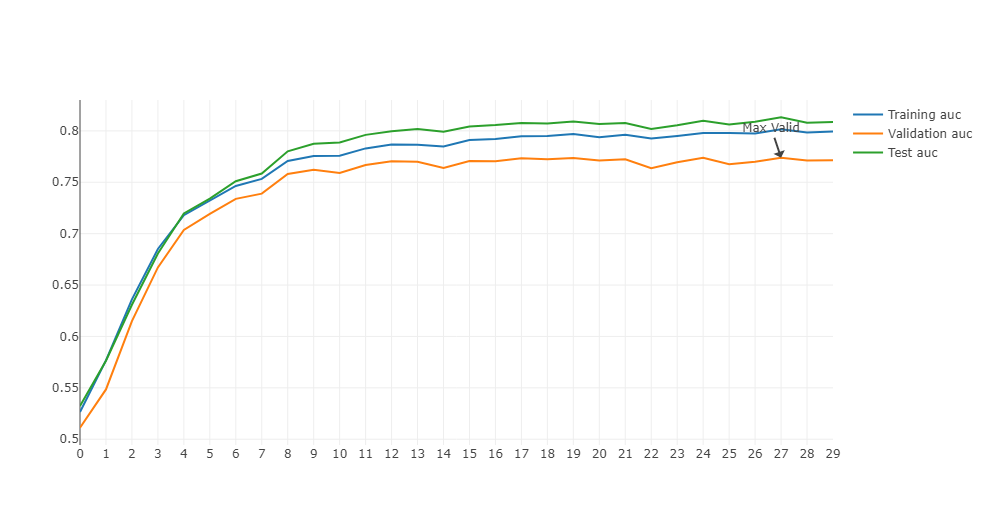

In [1]:
from IPython.display import Image
Image('img/LR_AUC_DIM2.png')